## Project 4: Land mine classification

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
  
# import dataset 
land_mines = fetch_ucirepo(id=763) 
  
# data (as pandas dataframes) 
X = land_mines.data.features 
y = land_mines.data.targets 
  
# metadata 
print(land_mines.metadata) 
  
# variable information 
print(land_mines.variables) 

{'uci_id': 763, 'name': 'Land Mines', 'repository_url': 'https://archive.ics.uci.edu/dataset/763/land+mines-1', 'data_url': 'https://archive.ics.uci.edu/static/public/763/data.csv', 'abstract': 'Detection of mines buried in the ground is very important in terms of safety of life and property. Many different methods have been used in this regard; however, it has not yet been possible to achieve 100% success. Mine detection process consists of sensor design, data analysis and decision algorithm phases. The magnetic anomaly method works according to the principle of measuring the anomalies resulting from the object in the magnetic field that disturbs the structure of it, the magnetic field, and the data obtained at this point are used to determine the conditions such as motion and position. The determination of parameters such as position, depth or direction of motion using magnetic anomaly has been carried out since 1970.', 'area': 'Engineering', 'tasks': ['Classification', 'Clustering']

In [28]:
y.describe

<bound method NDFrame.describe of      M
0    1
1    1
2    1
3    1
4    1
..  ..
333  5
334  5
335  5
336  5
337  5

[338 rows x 1 columns]>

In [29]:
X.shape

(338, 3)

In [30]:
y.shape

(338, 1)

In [31]:
X.head()

,V,H,S
0,0.338157,0.000000,0.0
1,0.320241,0.181818,0.0
2,0.287009,0.272727,0.0
3,0.256284,0.454545,0.0
4,0.262840,0.545455,0.0


In [32]:
X['S'].unique()

array([0. , 0.6, 0.2, 0.8, 0.4, 1. ])

In [33]:
y['M'].unique()

array([1, 2, 3, 4, 5])

## Preprocessing steps

This data is low dimensional. The three dimensions that are associated with identifying a mine are voltage, height (cm), and soil type. No dimensionality reduction measures are required at this moment. Soil is a categorical feature, so it will be one-hot encoded across the different soil types.

In [34]:
X.columns = ['voltage', 'height', 'soil']

In [35]:
# One-hot encoding for categorical soil feature
X = pd.get_dummies(X, columns=['soil'], dtype=int)

X.head()

,voltage,height,soil_0.0,soil_0.2,soil_0.4,soil_0.6,soil_0.8,soil_1.0
0,0.338157,0.000000,1,0,0,0,0,0
1,0.320241,0.181818,1,0,0,0,0,0
2,0.287009,0.272727,1,0,0,0,0,0
3,0.256284,0.454545,1,0,0,0,0,0
4,0.262840,0.545455,1,0,0,0,0,0


In [36]:
# clean up the soil names
X.rename(columns={
    'soil_0.0': 'D_S',
    'soil_0.2': 'D_H',
    'soil_0.4': 'D_L',
    'soil_0.6': 'H_S',
    'soil_0.8': 'H_H',
    'soil_1.0': 'H_L' }, inplace=True)
X.head()

,voltage,height,D_S,D_H,D_L,H_S,H_H,H_L
0,0.338157,0.000000,1,0,0,0,0,0
1,0.320241,0.181818,1,0,0,0,0,0
2,0.287009,0.272727,1,0,0,0,0,0
3,0.256284,0.454545,1,0,0,0,0,0
4,0.262840,0.545455,1,0,0,0,0,0


## Data understanding

To get a better understanding of the distributions of the continuous soil variables, I want to see if the counts for each type are relatively similar. 

<Axes: title={'center': 'Record Count per Soil Type'}, xlabel='Soil Type', ylabel='Count'>

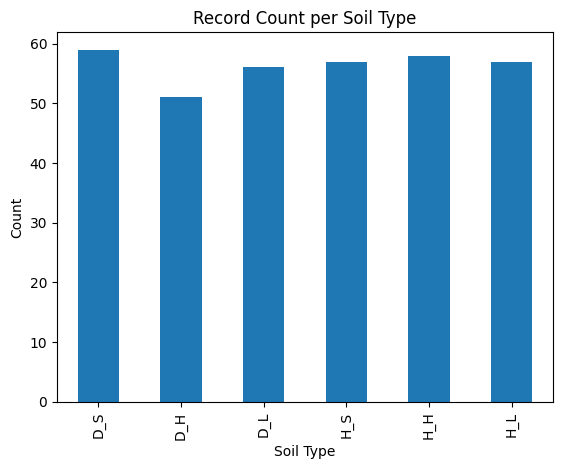

In [37]:
soil_counts = X[['D_S', 'D_H', 'D_L', 'H_S', 'H_H', 'H_L']].sum().astype(int)
soil_counts.plot(kind='bar', title='Record Count per Soil Type', ylabel='Count', xlabel='Soil Type')

I also want to see how the continuous voltage and heigh variables are distributed. A KDE plot will show density for both at different values.

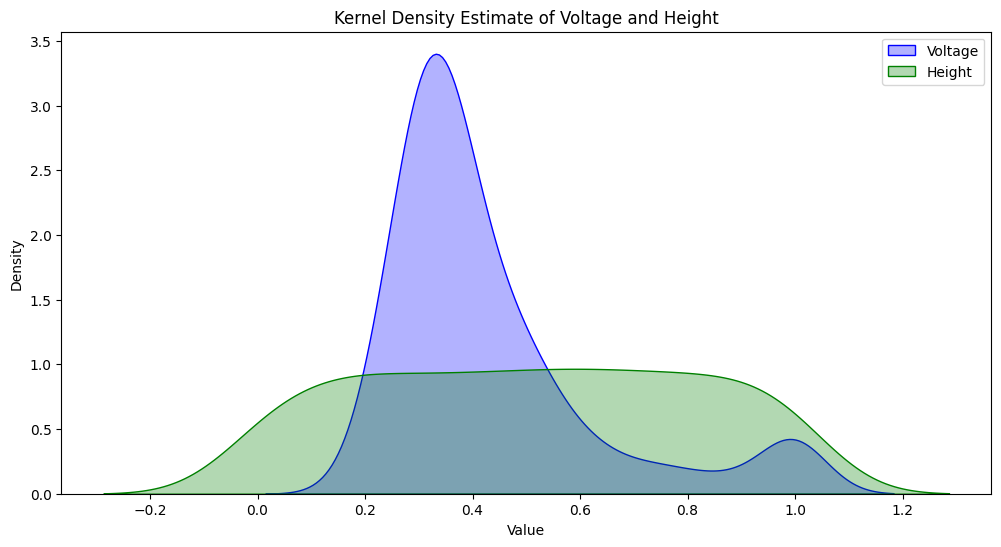

In [38]:
plt.figure(figsize=(12, 6))

# KDE for voltage
sns.kdeplot(X['voltage'], label='Voltage', fill=True, color='blue', alpha=0.3)

# KDE for height
sns.kdeplot(X['height'], label='Height', fill=True, color='green', alpha=0.3)

# Add labels and legend
plt.title("Kernel Density Estimate of Voltage and Height")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

plt.show()

<Axes: xlabel='voltage', ylabel='height'>

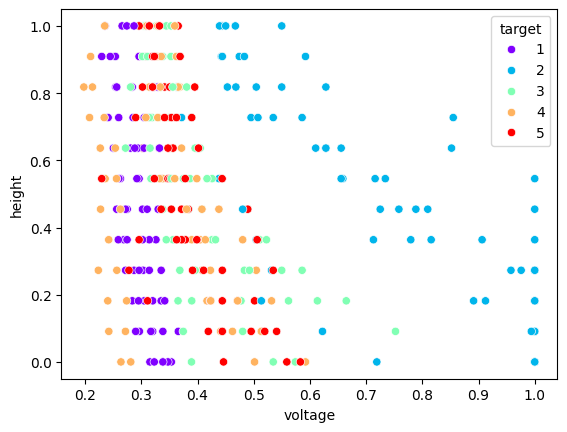

In [39]:
# are there patterns beween voltage and height with labeled data?

label_df = X.copy()
label_df['target'] = y['M']

sns.scatterplot(label_df, x='voltage', y='height', hue ='target', palette='rainbow')

## Cluster experimentation

Agglomerative clustering

In [40]:
X.head()

,voltage,height,D_S,D_H,D_L,H_S,H_H,H_L
0,0.338157,0.000000,1,0,0,0,0,0
1,0.320241,0.181818,1,0,0,0,0,0
2,0.287009,0.272727,1,0,0,0,0,0
3,0.256284,0.454545,1,0,0,0,0,0
4,0.262840,0.545455,1,0,0,0,0,0


In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# The following output should show progression of silhouette score and Davies-Bouldin Index as I repeat clustering with different cluster counts. 
# iteration 1: 5 clusters (5 mine types)
agglo = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=5)
X["cluster"] = agglo.fit_predict(X)

# eval
score = silhouette_score(X, X['cluster'])
db_index = davies_bouldin_score(X, X['cluster'])
print(f'Agglomerative (5 clusters) Silhouette Score: {score}')
print(f'Agglomerative (5 clusters) Davies-Bouldin Index: {db_index}\n')

# iteration 2: clusters = 6
agglo = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=6)
X["cluster"] = agglo.fit_predict(X)

#eval
score = silhouette_score(X, X['cluster'])
db_index = davies_bouldin_score(X, X['cluster'])
print(f'Agglomerative (6 clusters) Silhouette Score: {score}')
print(f'Agglomerative (6 clusters) Davies-Bouldin Index: {db_index}\n')

# I randomly decided to put in 10 clusters, ended up resulting with the best metrics:
agglo = AgglomerativeClustering(metric='euclidean', linkage='ward', n_clusters=10)
X["cluster"] = agglo.fit_predict(X)

score = silhouette_score(X, X['cluster'])
db_index = davies_bouldin_score(X, X['cluster'])
print(f'Agglomerative (10 clusters) Silhouette Score: {score}')
print(f'Agglomerative (10 clusters) Davies-Bouldin Index: {db_index}')

Agglomerative (5 clusters) Silhouette Score: 0.6595832770964867
Agglomerative (5 clusters) Davies-Bouldin Index: 0.5276808517764642

Agglomerative (6 clusters) Silhouette Score: 0.7537710535596642
Agglomerative (6 clusters) Davies-Bouldin Index: 0.3798182677462147

Agglomerative (10 clusters) Silhouette Score: 0.8082871449793197
Agglomerative (10 clusters) Davies-Bouldin Index: 0.2773464086261809


Test kmeans (as a comparison)

In [43]:
from sklearn.cluster import KMeans

kmeans_df = X.copy()
kmeans = KMeans(n_clusters=10, random_state=42) # same number of clusters that yielded good results in agglomerative
kmeans_df['cluster'] = kmeans.fit_predict(kmeans_df)

# Evaluate performance
print("Silhouette Score:", silhouette_score(kmeans_df, kmeans_df['cluster']))
print("Davies-Bouldin Index:", davies_bouldin_score(kmeans_df, kmeans_df['cluster']))

Silhouette Score: 0.8076146579101108
Davies-Bouldin Index: 0.2826762253731851


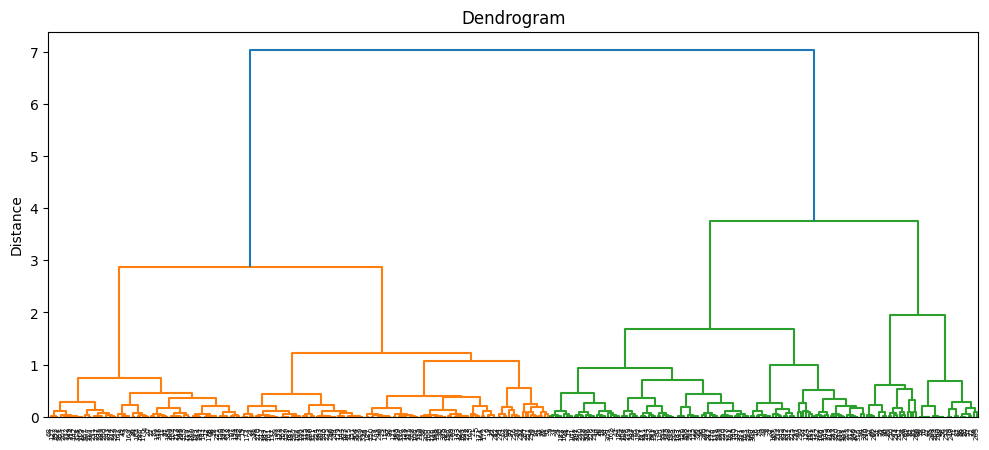

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X[['voltage', 'height']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 5))
dendrogram(Z)
plt.title("Dendrogram")
plt.ylabel("Distance")
plt.show()

Visualizing cluster groupings. 

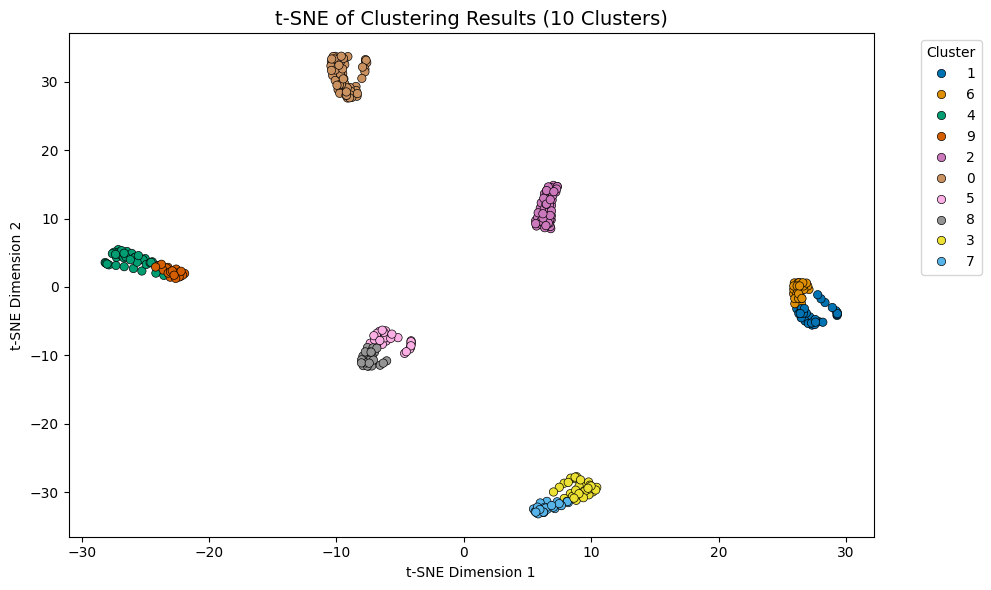

In [45]:
from sklearn.manifold import TSNE

# load features only
features = X.drop("cluster", axis=1)

# run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features)

# plot t-SNE findings
tsne_df = pd.DataFrame({
    't-SNE 1': tsne_result[:, 0],
    't-SNE 2': tsne_result[:, 1],
    'Cluster': X['cluster'].astype(str)
})

# visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x='t-SNE 1', y='t-SNE 2',
    hue='Cluster',
    palette='colorblind',
    edgecolor='black'
)
plt.title('t-SNE of Clustering Results (10 Clusters)', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
cluster_means = X.groupby('cluster').mean()
cluster_means = cluster_means.T
cluster_means

cluster,0,1,2,3,4,5,6,7,8,9
voltage,0.415468,0.497873,0.378237,0.538781,0.531307,0.562128,0.319610,0.350345,0.345158,0.344446
height,0.484326,0.272727,0.500891,0.275660,0.324675,0.285266,0.787879,0.793706,0.787879,0.830579
D_S,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
D_H,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
D_L,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
H_S,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
H_H,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H_L,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


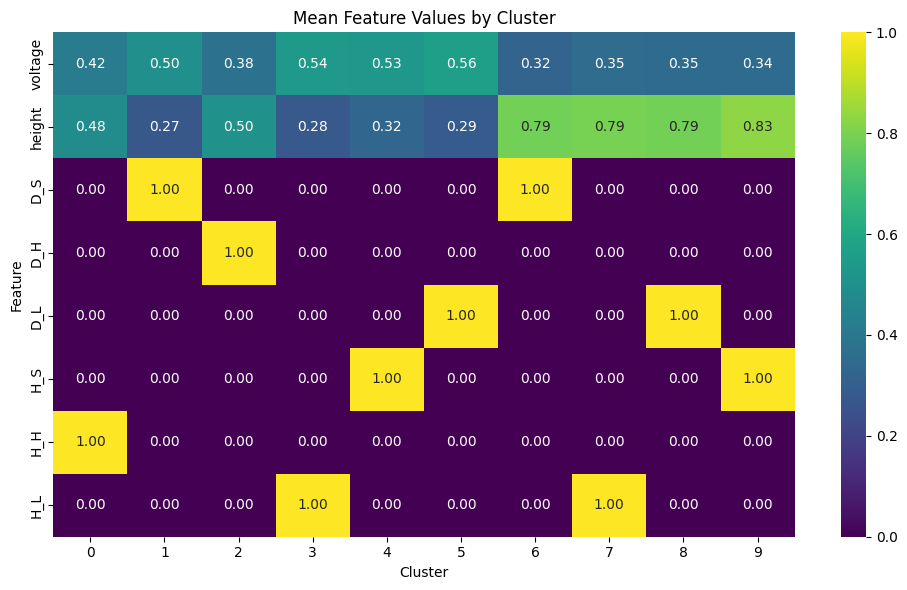

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, cmap="viridis", annot=True, fmt=".2f")
plt.title("Mean Feature Values by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()